# 加载基本库

In [1]:
import collections
import pandas as pd
import datetime
import ffmyh
import time
import math
# from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import sklearn
from sklearn.feature_extraction import DictVectorizer

%run FeatureProcess.py
# from fastFM.datasets import make_user_item_regression
# from fastFM import als
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
import numpy as np

sklearn.__version__

'0.19.1'

# 加载数据项

In [2]:
train_df_org = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
test_df_org = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')



In [3]:
train_df_org.columns

train_df = train_df_org.copy().set_index("context_id")
test_df = test_df_org.copy().set_index("context_id")

test_df["is_trade"] = -1
train_df_prev = train_df.append(test_df)
# print len(train_df)
# print train_df[["is_trade"]]

# 预处理数据

In [4]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from datetime import datetime

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime("%Y-%m-%d")
def extract_time(x):
    d = datetime.fromtimestamp(x)
    return d.strftime("%Y-%m-%d %H:%M:%S")
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

# train_df_prev['time'] = train_df_prev['context_timestamp'].apply(lambda x: extract_time(x))
train_df_prev['date'] = train_df_prev['context_timestamp'].apply(lambda x: extract_date(x))
train_df_prev['weekday'] = train_df_prev['context_timestamp'].apply(lambda x: extract_weekday(x))
train_df_prev['hour'] = train_df_prev['context_timestamp'].apply(lambda x: extract_hour(x))

m = {}
for idx, date in enumerate(sorted(train_df_prev['date'].unique())):
    m[date]=idx
print(m)

for idx, d in enumerate(sorted(train_df_prev['date'].unique())):
    train_df_prev["day"] = train_df_prev['date'].map(lambda x: m[x])

{'2018-09-18': 0, '2018-09-19': 1, '2018-09-20': 2, '2018-09-21': 3, '2018-09-22': 4, '2018-09-23': 5, '2018-09-24': 6, '2018-09-25': 7}


# 拆解复杂类型

In [6]:
#简化list等复杂类型的结构
#item_category_list全展开
#item_property_list全展开取频率>0.05的数据
#predict_category_property会计算跟item prop和cate的余弦相似度
#具体是把两个list的数据拼成cate:-1和cate:prop两种方式拼成一个字符串再跟predict_category_property的数据计算相似度
def get_icl_map(df):
    print("get_icl_map ... ")
    dfX = df.copy()
    dfX = dfX['item_category_list'].str.split(';', expand=True)

#     s = sorted(list(dfX[0].unique()) + list(dfX[1].unique()) + list(dfX[2].unique()))
    m = {}
    for i in dfX[0].unique():
        if i == None:
            continue
        m[i] = "1"
    
    for i in dfX[1].unique():
        if i == None:
            continue
        m[i] = "2"
    
    for i in dfX[2].unique():
        if i == None:
            continue
        m[i] = "3"
    return m

def get_ipl_map(df):
    print("get_ipl_map ... ")
    df1 = df.copy()
    dfX = df1.copy()['item_property_list'].str.split(';')
    dfX = pd.DataFrame(dfX)
    
    m = collections.defaultdict(float)
    idx = 0
    for _, row in dfX.iterrows():
        for i in row[0]:
            m[i] += 1
    
    ll = len(dfX)
    for k,v in m.items():
        m[k] = v / ll
    return m

def process_complex_types(dfX, icl_map, ipl_map):
    def filter_unless_cate(arr):
        ret = []
        for i in arr:
            if i in icl_map:
                ret.append(i)
        if len(ret) == 0:
            return None
        else:
            return ret
    
    def filter_unless_prop(arr):
        ret = []
        for i in arr:
            freq = ipl_map.get(i, 0.)
            if freq > 0.05:
                ret.append(i)
            else:
                ret.append(1)
        if len(ret) == 0:
            return None
        else:
            return unique_list(ret)
    
    def unique_list(arr):
        return list(set(arr))
    
    #{cate}:-1命中则为1分
    #{cate}:{prop}命中则为2分
    #后期优化权重
    def inner_product_recall_items(line):
        line = line.split("|")
        item_category_list = unique_list(line[0].split(";"))
        item_property_list = unique_list(line[1].split(";"))
        
        whole_combines = {}
        for cate in item_category_list:
            tmp = cate+":"+"-1"
            whole_combines[tmp] = 1
            for prop in item_property_list:
                tmp = cate+":"+prop
                whole_combines[tmp] = 2
        
        
                
        predict_category_property = unique_list(line[2].split(";"))
        product = 0.
        item_vec_len = math.sqrt(len(whole_combines))
        user_vec_len = math.sqrt(len(predict_category_property))
        for item in predict_category_property:
            #x1 == 1
            #y1 == 1
            #x1*y1 == 1
            #x2 == 0
            #y2 == 1
            #x2*y2 == 0
            #所以product由x决定 += 1/0
            product += whole_combines.get(item, 0)
        
        return product/(item_vec_len*user_vec_len)
            
        
            
        
        
        
    print("processing predict_category_property ...")
#     dfX['predict_category_property'] = dfX['predict_category_property'].str.split(';').map(lambda x: [i.split(":")[0] for i in x]).map(filter_unless_cate)
    
    dfX['predict_richness'] =  dfX['predict_category_property'].map(lambda x: 0 if len(x.strip()) == 0 else len(x.split(";")))
    dfX['predict_category_property'] = dfX['item_category_list']+"|"+dfX['item_property_list']+"|"+dfX['predict_category_property']
    dfX['predict_category_property'] = dfX['predict_category_property'].map(inner_product_recall_items)
    
    print("processing item_property_list ...")
    dfX['item_property_richness'] = dfX['item_property_list'].map(lambda x: 0 if len(x.strip()) == 0 else len(x.split(";")))
    dfX['item_property_list'] = dfX['item_property_list'].str.split(';').map(filter_unless_prop)
    
    print("processing item_category_list ...")
    dfX['item_category_list'] = dfX['item_category_list'].str.split(';')
    
    print( "generating item_category_1, item_category_2 ...")
#     dfX['item_category_list01'] = dfX['item_category_list'].map(lambda x:x[0] if x != None and len(x) > 0 else None)
    dfX['item_category_1'] = dfX['item_category_list'].map(lambda x:x[1] if x != None and len(x) > 1 else None)
    dfX['item_category_2'] = dfX['item_category_list'].map(lambda x:x[2] if x != None and len(x) > 2 else None)
    
    return dfX



# aaa = process_complex_types(train_df.copy(), get_icl_map(train_df), get_ipl_map(train_df))

train_df_prev = process_complex_types(train_df_prev, get_icl_map(train_df_prev), get_ipl_map(train_df_prev))


get_icl_map ... 
get_ipl_map ... 
processing predict_category_property ...
processing item_property_list ...
processing item_category_list ...
generating item_category_1, item_category_2 ...


## 统计一个用户重复看某个商品的次数+一个用户重复看某类商品的次数

In [7]:
cnt_user_item_review = train_df_prev[["user_id", "item_id", "instance_id"]].groupby(["user_id", "item_id"])['instance_id'].count().to_dict() 
cnt_user_cate_review = train_df_prev[["user_id", "item_category_1", "instance_id"]].groupby(["user_id", "item_category_1"])['instance_id'].count().to_dict()  

class set_review_cnt:
    def __init__(self, key1, key2, cnt_k1_k2_review):
        self.key1 = key1
        self.key2 = key2
        self.tmp = collections.defaultdict(int)
        self.cnt_k1_k2_review = cnt_k1_k2_review
    def __call__(self, x):
        val1,val2 = x[self.key1], x[self.key2]
        vk = (val1, val2)

        cnt = self.cnt_k1_k2_review[vk]
        if cnt == 0:
            return 0
        else:
            
            k = "%s_%s" % (val1, val2)
            ret = self.tmp[k]
            self.cnt_k1_k2_review[vk] -= 1
            self.tmp[k] += 1
            return ret
        
f1 = set_review_cnt("user_id", "item_id", cnt_user_item_review)
f2 = set_review_cnt("user_id", "item_category_1", cnt_user_cate_review)
train_df_prev = train_df_prev.sort_values(by="context_timestamp")
train_df_prev["item_review_cnt"] = train_df_prev[["user_id", "item_id"]].apply(f1, axis=1)
train_df_prev["cate_review_cnt"] = train_df_prev[["user_id", "item_category_1"]].apply(f2, axis=1)

# 转化属性增加trade_rate + trade_pv（按前一天）

In [8]:
# 统计信息附加

def calcTVTransform(df, key, key_y, filter_src, filter_dst, smoothing = 5, mean0=None):
    if mean0 is None:
        #计算目标的平均值做平缓用
        mean0 = df.ix[filter_src, key_y].mean()
        print("mean0:", mean0)
    
    #取出key的所有值
    df['_key1'] = df[key].astype('category').values.codes
    
    
    #取出用于计算的源（后面聚合掉就没有顺序可言了）
    df_key1_y = df.ix[filter_src, ['_key1', key_y]]
    
    #根据key的取值去聚合key_y的总数和总和，用户计算rate和count
    grp1 = df_key1_y.groupby(['_key1'])
    sum1 = grp1[key_y].aggregate(np.sum)
    cnt1 = grp1[key_y].aggregate(np.size)
    
    vn_sum = 'sum_' + key
    vn_cnt = 'cnt_' + key
    
    #取出dst（带序列）的所有key
    v_codes = df.ix[filter_dst, '_key1']
    
    #得到_sum,_cnt，按dst的序列
    _sum = sum1[v_codes].values
    _cnt = cnt1[v_codes].values
    _cnt[np.isnan(_sum)] = 0    
    _sum[np.isnan(_sum)] = 0
    
    r = {}
    r['exp'] = (_sum + smoothing * mean0)/(_cnt + smoothing)
    r['cnt'] = _cnt
    return r


In [9]:
#计算前一天的交易率set到下一天，第0天用回自己
# tmp = train_df.copy()
tmp = train_df_prev

add_count = False
# window = 2

exp = "exp_d_"
cnt = "cnt_d_"


exp_numerical = {}
cnt_numerical = {}

In [ ]:

k = "day"
exp_k = "exp_d_day"
for day in range(0,7):
    cal_day = day
    set_day = day

    print("cal %s trade_rate cnt %s set to %s" % (k,cal_day, set_day))

    #start_d - day(不含day)用于计算，结果赋值到day上
    days1 = (tmp.day.values == cal_day)
    days2 = (tmp.day.values == set_day)
    ret = calcTVTransform(tmp, k, 'is_trade', days1, days2, 0)

    tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]

    exp_numerical[exp_k]=1

tmp.loc[tmp.day.values == 7, exp_k] = 0.0169

tmp[[exp_k, "day"]]

In [ ]:


#此处应该处理按天为梯度的数据
for k in ['item_price_level',
'item_sales_level',
'item_collected_level',
'item_pv_level',
'user_gender_id',
'user_age_level',
'user_occupation_id',
'user_star_level',
'context_page_id',
'shop_review_num_level',
'shop_star_level',
         

"item_brand_id",
"item_city_id",
"item_id",
"shop_id",
          
"item_brand_id",
"item_city_id"
         ]:
    exp_k = exp+k
    cnt_k = cnt+k
    for day in range(0,8):
#         start_d = max(day - window, 0)
#         end_d = max(day - 1,0)
        cal_day = max(day - 1, 0)
        set_day = day

        print("cal %s trade_rate cnt %s set to %s" % (k,cal_day, set_day))
        
        #start_d - day(不含day)用于计算，结果赋值到day上
        days1 = (tmp.day.values == cal_day)
        days2 = (tmp.day.values == set_day)
        ret = calcTVTransform(tmp, k, 'is_trade', days1, days2)
            
        tmp.loc[tmp.day.values == day, exp_k] = ret["exp"]
        
        exp_numerical[exp_k]=1
        if add_count:
            cnt_numerical[cnt_k]=1
            tmp.loc[tmp.day.values == day, cnt_k] = ret["cnt"]


In [15]:
exp_numerical = exp_numerical.keys()
cnt_numerical = cnt_numerical.keys()

print(exp_numerical)
print(cnt_numerical)



dict_keys(['exp_d_day', 'exp_d_item_price_level', 'exp_d_item_sales_level', 'exp_d_item_collected_level', 'exp_d_item_pv_level', 'exp_d_user_gender_id', 'exp_d_user_age_level', 'exp_d_user_occupation_id', 'exp_d_user_star_level', 'exp_d_context_page_id', 'exp_d_shop_review_num_level', 'exp_d_shop_star_level', 'exp_d_item_brand_id', 'exp_d_item_city_id', 'exp_d_item_id', 'exp_d_shop_id'])
dict_keys([])


In [16]:
print( "RECOVER")
train_df = train_df_prev.copy()

RECOVER


# 标记训练用的列

In [24]:
#标记训练数据

import copy
target="is_trade"
                          
%run FeatureProcess.py
                          
                        
categorical=[  
                'item_price_level',
                'item_sales_level',
                'item_collected_level',
                'item_pv_level',
                'user_gender_id',
                'user_age_level',
                'user_occupation_id',
                'user_star_level',
                'context_page_id',
                'shop_review_num_level',
                'shop_star_level',
                "weekday",
                "hour",
    
                'item_category_1',
                'item_category_2',
                
                "item_brand_id",
                "item_city_id",
                "item_id",
                "shop_id",
    
                "item_review_cnt",
                "cate_review_cnt"
            ]

numerical=[     'shop_review_positive_rate',
                'shop_score_service',
                'shop_score_delivery',
                'shop_score_description',
                'predict_category_property',
                'predict_richness',
                'item_property_richness'
                   
#               ]
          ]+list(exp_numerical)

listype = [
    'item_property_list', 
#     'item_category_list'
]

                    
            

cols_tool = filter_on_cols(target, categorical, numerical, listype)

In [25]:
train_df[cols_tool.get_raw_numerical_cols()].describe()

,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description,predict_category_property,predict_richness,item_property_richness,exp_d_day,exp_d_item_price_level,exp_d_item_sales_level,exp_d_item_collected_level,exp_d_item_pv_level,exp_d_user_gender_id,exp_d_user_age_level,exp_d_user_occupation_id,exp_d_user_star_level,exp_d_context_page_id,exp_d_shop_review_num_level,exp_d_shop_star_level,exp_d_item_brand_id,exp_d_item_city_id,exp_d_item_id,exp_d_shop_id
count,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000
mean,0.994833,0.971131,0.970495,0.974870,0.104144,4.810191,34.475055,0.018794,0.019127,0.019192,0.019203,0.019182,0.019201,0.019208,0.019196,0.019191,0.019204,0.019205,0.019197,0.019156,0.019149,0.019465,0.019042
std,0.011875,0.023607,0.023567,0.024823,0.074287,1.795871,10.150529,0.001128,0.008326,0.005930,0.003000,0.002667,0.001897,0.003049,0.001746,0.002817,0.002717,0.003738,0.003774,0.017160,0.007948,0.023115,0.020898
min,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,6.000000,0.016900,0.000991,0.000521,0.000545,0.000722,0.010104,0.000985,0.000985,0.000985,0.004171,0.000925,0.000531,0.000229,0.000455,0.000287,0.000237
25%,0.992780,0.966360,0.965677,0.969282,0.052705,3.000000,29.000000,0.017276,0.014194,0.015125,0.017904,0.017939,0.018869,0.017564,0.018679,0.018385,0.018735,0.017704,0.016705,0.006876,0.013794,0.004033,0.004389
50%,1.000000,0.972347,0.971579,0.978493,0.099015,5.000000,33.000000,0.019312,0.016366,0.019286,0.019162,0.019256,0.019397,0.019105,0.019032,0.019564,0.019370,0.018837,0.018953,0.017874,0.016974,0.011792,0.012949
75%,1.000000,0.977822,0.976966,0.983626,0.148888,6.000000,39.000000,0.019681,0.023363,0.022024,0.020535,0.020019,0.019800,0.020800,0.019854,0.020864,0.020518,0.021641,0.022550,0.024959,0.022694,0.025886,0.027273
max,1.000000,1.000000,1.000000,1.000000,0.632456,14.000000,100.000000,0.020021,0.109656,0.037044,0.035202,0.182390,0.023104,0.027449,0.022760,0.054228,0.026027,0.084623,0.122234,0.231820,0.189505,0.299543,0.262301


# 平滑处理连续型数据最后对复杂类型做onehot编码

In [26]:
#数据的预处理
#double系列(例如好评率)的数据存在一个问题，没有考虑到评论量，所以乘了一个评论level，类似 好评率*评论数(分桶了) = 好评量(分桶了)
#fillempty把-1设置成-0.01，配合mov2pos使用
#mov2pos把有<0的数据都集体-min，如果一个数据是0-1，有-1出现的时候，上面设置成了-0.01，所以这列数据真实是-0.01 - 1,然后我会集体-(-0.01)
#norm用了最大值最小值norm
%run FeatureProcess.py
from sklearn import preprocessing

def bucketizer(df, key, bins):
    le = preprocessing.LabelEncoder()
    prefix="*BUK*_"
    df[prefix+key] = pd.cut(df[key].values, bins=bins, retbins=False)
    df[prefix+key] = le.fit_transform(df[prefix+key].copy())
    return df


def layering(df, key, by_key):
    uniqv = df[by_key].unique()
    keys = []
    for v in uniqv:
        indexer = (df[by_key] == v)
        new_key = "*%sLAY*_%s" % (str(v), key)
        df.loc[indexer, new_key] = df[indexer][key]
        keys.append(new_key)
    return df, keys

# #分桶+打散
# print("bucketizer ... ")
# train_df = bucketizer(train_df, "shop_review_num_level", 5)

# print("layering ... ")
# new_n = []
# for n in numerical:
#     train_df, keys = layering(train_df, n, '*BUK*_shop_review_num_level')
#     new_n += keys



featProc = FeatureProcess(target=target, categorical=categorical, numerical=numerical, listype = listype)
# for n in numerical:
#     featProc.addLayeringOrgKeys(n)
# train_df["shop_review_num_level"] = train_df["shop_review_num_level"]
# train_df["shop_review_positive_rate"] = train_df["shop_review_positive_rate"]*train_df["shop_review_num_level"]
# train_df["shop_score_service"] = train_df["shop_score_service"]*train_df["shop_review_num_level"]
# train_df["shop_score_delivery"] = train_df["shop_score_delivery"]*train_df["shop_review_num_level"]
# train_df["shop_score_description"] = train_df["shop_score_description"]*train_df["shop_review_num_level"]

train_df = featProc.fillempty(train_df, -0.01)
# train_df = featProc.mov2pos(train_df)
train_df = featProc.mov2mean(train_df)
train_df = featProc.norm(train_df)
train_df[cols_tool.get_raw_numerical_cols()].describe()


,shop_review_positive_rate,shop_score_service,shop_score_delivery,shop_score_description,predict_category_property,predict_richness,item_property_richness,exp_d_day,exp_d_item_price_level,exp_d_item_sales_level,exp_d_item_collected_level,exp_d_item_pv_level,exp_d_user_gender_id,exp_d_user_age_level,exp_d_user_occupation_id,exp_d_user_star_level,exp_d_context_page_id,exp_d_shop_review_num_level,exp_d_shop_star_level,exp_d_item_brand_id,exp_d_item_city_id,exp_d_item_id,exp_d_shop_id
count,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000,496509.000000
mean,0.982014,0.865794,0.827843,0.883320,0.164666,0.293092,0.302926,0.606917,0.166898,0.511220,0.538369,0.101611,0.699759,0.688612,0.836325,0.341940,0.687828,0.218402,0.153373,0.081723,0.098886,0.064086,0.071759
std,0.032251,0.043904,0.054594,0.056408,0.117458,0.138144,0.107984,0.361303,0.076621,0.162354,0.086564,0.014680,0.145956,0.115209,0.080191,0.052908,0.124316,0.044658,0.031012,0.074096,0.042041,0.077242,0.079743
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.974731,0.842328,0.798142,0.856064,0.083333,0.153846,0.244681,0.120499,0.121504,0.399855,0.500887,0.094769,0.674225,0.626489,0.812573,0.326793,0.666383,0.200471,0.132899,0.028698,0.070562,0.012521,0.015845
50%,1.000000,0.870375,0.832816,0.899184,0.156556,0.307692,0.287234,0.772863,0.141488,0.513787,0.537175,0.102018,0.714830,0.684715,0.828809,0.348955,0.695428,0.214012,0.151369,0.076188,0.087382,0.038448,0.048508
75%,1.000000,0.896039,0.864508,0.923249,0.235412,0.384615,0.351064,0.891105,0.205879,0.588760,0.576776,0.106222,0.745833,0.748742,0.866525,0.373371,0.747943,0.247507,0.180926,0.106783,0.117639,0.085545,0.103168
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# #onehot没啥好说的，就是onehot，toOneHotList实现有点不同分开了而已


# # train_df = featProc.toOneHot(train_df)
# train_df = featProc.toOneHotList(train_df)

# # train_df = featProc.cacheRun(featProc.toOneHot, train_df)

# for c in train_df.columns:
#     print(c)

# print train_df.columns

# 定义模型函数

In [45]:
%run ffmyh.py

    
# def train_and_test_combine(train_df, test_df, res_df):
    
#     X_train = train_df.copy()
#     del X_train['is_trade']
#     y_train = train_df['is_trade']
    
#     X_test = test_df.copy()
#     del X_test['is_trade']
#     y_test = test_df['is_trade']
    
    
    
#     model = xgboost.XGBClassifier(nthread=7,max_depth=5)
#     model.fit(X_train, y_train)
    
#     y_prev_predict_train = pd.DataFrame(model.predict_proba(X_train))
#     y_prev_predict_train["idx"] = X_train.index
#     y_prev_predict_train = y_prev_predict_train.set_index("idx")
#     X_train["y_prev_predict"] = y_prev_predict_train[1]
    
#     y_prev_predict_test = pd.DataFrame(model.predict_proba(X_test))
#     y_prev_predict_test["idx"] = X_test.index
#     y_prev_predict_test = y_prev_predict_test.set_index("idx")
#     X_test["y_prev_predict"] = y_prev_predict_test[1]
    
    
# #     X_train = X_train.fillna(0)
# #     X_test = X_test.fillna(0)
    
    
#     model = LogisticRegression(max_iter=1000)
#     model.fit(X_train, y_train)
    
    
#     train_lls = log_loss(y_train,model.predict_proba(X_train))
#     test_lls = log_loss(y_test,model.predict_proba(X_test))
#     del train_df
#     del test_df
    
#     del X_train
#     del y_train
#     del X_test
#     del y_test
    
#     return train_lls, test_lls
    

def train_and_test_xgboost(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
#     model = xgboost.XGBClassifier(reg_lambda=1.5,learning_rate=0.1,reg_alpha=0,nthread=7,n_estimators=100,max_depth=10)
    # model = xgboost.XGBClassifier(subsample=0.9,colsample_bytree=0.9,n_estimators=500,max_depth=7,nthread=3)
    model = xgboost.XGBClassifier(n_jobs=7, max_depth=3, n_estimators=230)

#     model = xgboost.XGBClassifier(subsample=0.9,colsample_bytree=0.9,n_estimators=50,max_depth=3,nthread=1)
    model.fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(12,18))
    xgboost.plot_importance(model,ax=ax)
    plt.show()
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        # del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("xgb_8160.csv",index=False,sep=' ')
        
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_lr(train_df, test_df, res_df):    
    X_train = train_df.copy().fillna(0)
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy().fillna(0)
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
    
    model = LogisticRegression(C=1.0, n_jobs=7,tol=1e-6, max_iter=2000)
    model.fit(X_train.values, y_train)
#     for idx, val in enumerate(list(X_train.columns)):
#         print("%s=%s" %(val,list(model.coef_[0])[idx]))


    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        res_df = res_df.copy().fillna(0)
        # del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("lr_res.csv",index=False,sep=' ')
    
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_randomforest(train_df, test_df, res_df):    
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
#     rf = RandomForestClassifier(n_estimators=32, max_depth=40, min_samples_split=100, min_samples_leaf=10,  criterion='entropy',
#                         max_features=8, verbose = 1,  bootstrap=False, n_jobs=10)
#     RandomForestClassifier(criterion='entropy',n_estimators=100,n_jobs=15)

    model = RandomForestClassifier(n_jobs=7, n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10,  criterion='entropy', max_features=8, verbose = 1,  bootstrap=False)
    model.fit(X_train, y_train)
    
    ft_w = pd.DataFrame(model.feature_importances_, columns=["weights"], index = list(X_train.columns))
    print( ft_w.sort_values("weights", ascending=False))
#     fig, ax = plt.subplots(figsize=(12,18))
#     xgboost.plot_importance(model,ax=ax)
#     plt.show()
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        # del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("rf_8211.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls

def train_and_test_gbdt(train_df, test_df, res_df):
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    model = GradientBoostingClassifier(n_estimators=100, max_depth=10, min_samples_split=100, min_samples_leaf=10, max_features=4)
    model.fit(X_train, y_train)
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("gbdt_res.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls


def train_and_test_lgb(train_df, test_df, res_df, target, features, categorical):
    X_train = train_df.copy()
    del X_train['is_trade']
    y_train = train_df['is_trade']
    
    X_test = test_df.copy()
    del X_test['is_trade']
    y_test = test_df['is_trade']
    
    
    
    
#     test['lgb_predict'] = clf.predict_proba(test[features],)[:, 1]
#     print(log_loss(test[target], test['lgb_predict']))

    
    model = lgb.LGBMClassifier(num_leaves=10, max_depth=7, n_estimators=80, n_jobs=4)
    model.fit(X_train, y_train, feature_name=features,categorical_feature=categorical)
    
    ft_w = pd.DataFrame(model.feature_importances_, columns=["weights"], index = list(X_train.columns))
    print(ft_w)
#     fig, ax = plt.subplots(figsize=(12,18))
#     xgboost.plot_importance(model,ax=ax)
#     plt.show()
    
    train_lls = log_loss(y_train,model.predict_proba(X_train))
    test_lls = log_loss(y_test,model.predict_proba(X_test))
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("lgb_res.csv",index=False,sep=' ')
        
    del train_df
    del test_df
    
    del X_train
    del y_train
    del X_test
    del y_test
    
    return train_lls, test_lls


def train_and_test_FFM(train_df, test_df, res_df):
    global cols_tool
    
    model = FFM(target=cols_tool.target, categorical=cols_tool.categorical, numerical=cols_tool.numerical, listype=cols_tool.listype,
                                        reg_param = 0.0004,
                                        k = 4,
                                        iter_max = 500,
                                        learing_rate = 0.1,
                                        threads = 7,
                                        auto_stop = False,
                                        quiet = False,
                                        no_norm = False)


    
    model.fit(train_df, test_df)
    
    train_lls = log_loss(train_df["is_trade"],model.predict_proba(train_df))
    test_lls = log_loss(test_df["is_trade"],model.predict_proba(test_df))
    
    
    if type(res_df) != type(None):
        del res_df["is_trade"]
        res_df = res_df.reset_index(drop=True)
        instance_id_list = res_df[["instance_id"]]
        del res_df["instance_id"]
        predicted_score = pd.DataFrame(model.predict_proba(res_df))
        
        instance_id_list["predicted_score"] = predicted_score[1]
        instance_id_list.to_csv("ffm.csv",index=False,sep=' ')
        
    
    return train_lls, test_lls


def select_best_features(df, precent=0.8):
    from sklearn.feature_selection import SelectKBest,chi2 
    df = df.copy().replace(-1, 0).fillna(0)
    
    for u in df.columns:
        df[df[u] == -1] = 0

    X_train = df.copy()
    del X_train['is_trade']
    y_train = df['is_trade']
    
    c = int(len(X_train.columns) * precent)
    skb = SelectKBest(chi2,k=c)
    skb.fit_transform(X_train,y_train)
    
    old_fea = list(X_train.columns)
    new_fea = []
    for idx, b in enumerate(list(skb.get_support())):
        if b:
            new_fea.append(old_fea[idx])
        else:
            print("Filter feature:%s" % old_fea[idx])
    return new_fea

# 开搞！

org dataset = 496509
0    78268
3    71199
1    70931
2    68387
4    68318
5    63614
6    57421
7    18371
Name: day, dtype: int64
0    78268
3    71199
1    70931
2    68387
4    68318
5    63614
6    57421
7    18371
Name: day, dtype: int64
res dataset = 18371
valid dateset = 57421
train dateset = 478138


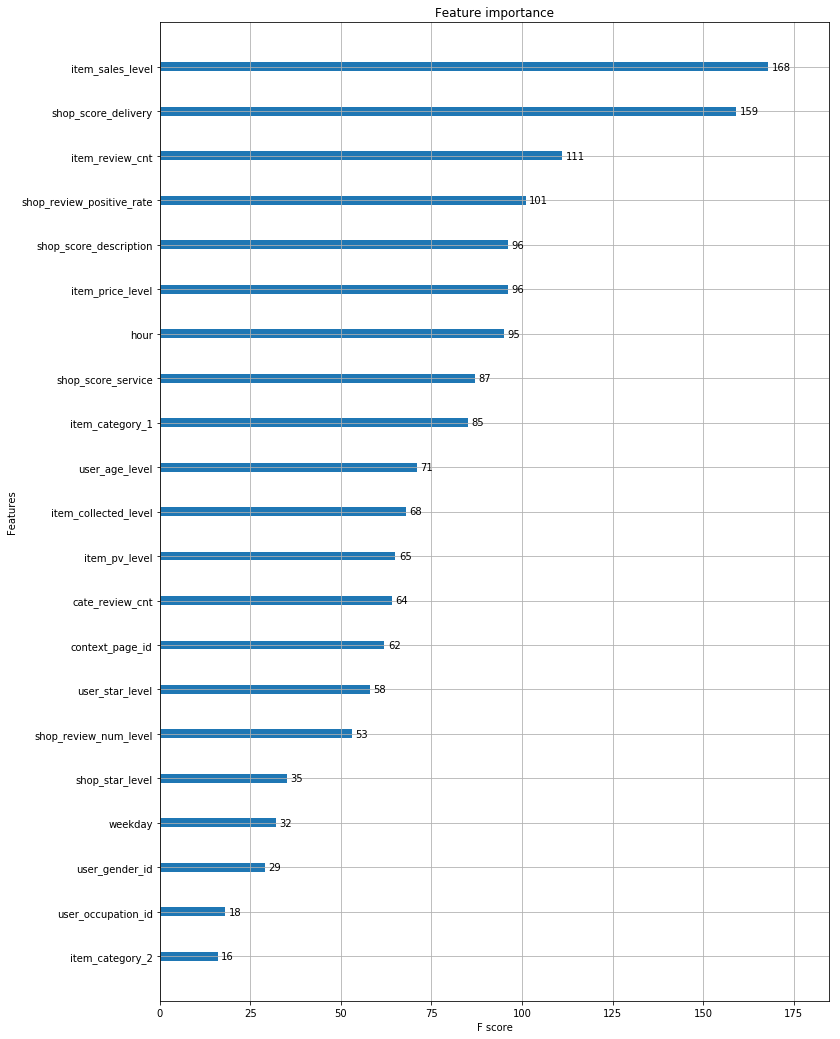

/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


XGBoost 21 dimension TrainLogLoss = 0.0873422651439 | TestLogLoss = 0.0800819499604


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   19.2s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   47.6s finished


                            weights
item_price_level           0.166678
item_review_cnt            0.102134
shop_score_delivery        0.095935
shop_score_service         0.086855
item_sales_level           0.079476
item_category_1            0.065676
shop_score_description     0.064832
hour                       0.061632
shop_review_positive_rate  0.039599
user_age_level             0.035369
user_star_level            0.034416
shop_review_num_level      0.023818
item_collected_level       0.022644
shop_star_level            0.021794
cate_review_cnt            0.021521
context_page_id            0.021343
item_pv_level              0.017670
weekday                    0.013315
user_occupation_id         0.009380
item_category_2            0.008169
user_gender_id             0.007743


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForest 21 dimension TrainLogLoss = 0.084547560987 | TestLogLoss = 0.0771327729286


/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
#这块一般不怎么需要改了，拿最后一天做验证
#注意下面验证版和测试版，测试版是我们自己玩的，验证版是扔线上的，通过注释不同的跑就行了


# %run BaseFrame.py
% run ../util/time_series_split.py

tmp_train_df = train_df.copy().fillna(-1)
tmp_train_df["item_category_1"] = tmp_train_df["item_category_1"].astype('int')
tmp_train_df["item_category_2"] = tmp_train_df["item_category_2"].astype('int')

# tmp_train_df["user_gender_id*shop_review_positive_rate"] = tmp_train_df["user_gender_id"] * (1+tmp_train_df["shop_review_positive_rate"])

# tmp_train_df["user_gender_id*shop_star_level"] = tmp_train_df["user_gender_id"] * (1+tmp_train_df["shop_star_level"])


cols_tool.fit(train_df)

categorical_one_hot_cols = cols_tool.get_onehoted_cols("categorical")
listype_one_hot_cols = cols_tool.get_onehoted_cols("listype")

index_col = "instance_id"


categorical_cols = cols_tool.get_raw_categorical_cols()
listype_cols = cols_tool.get_raw_listype_cols()
numerical_cols = cols_tool.get_raw_numerical_cols()
target_col = cols_tool.get_raw_target_col()


print("org dataset = %s" % len(tmp_train_df))
print(tmp_train_df["day"].value_counts())


# tmp_train_df = featProc.balance_pos_neg_sample(tmp_train_df, (1,10))
# print "sampling dataset =", len(tmp_train_df)
# print tmp_train_df["day"].value_counts()

# 抽样
# tmp_train_df = tmp_train_df.sample(n=10000, random_state=666)
# print "sampling dataset =", len(tmp_train_df)

print(tmp_train_df["day"].value_counts())

#测试版
# valid_df = tmp_train_df.loc[tmp_train_df["day"]==6]
# tmp_train_df = tmp_train_df.loc[tmp_train_df["day"]<6]
# # tmp_train_df = tmp_train_df.loc[tmp_train_df["day"]>0]
# res_df=valid_df.copy()

# #线上验证版
valid_df = tmp_train_df.loc[tmp_train_df["day"]==6]
res_df = tmp_train_df.loc[tmp_train_df["day"]==7].copy()
tmp_train_df = tmp_train_df.loc[tmp_train_df["day"]<=6]
#res_df = res_df.drop(['item_category_list', 'item_property_list', 'date'], axis=1)


print("res dataset = %s" % len(res_df))
print("valid dateset = %s" % len(valid_df))
print("train dateset = %s" % len(tmp_train_df))





use_fea1=[  
                'item_price_level',
                'item_sales_level',
                'item_collected_level',
                'item_pv_level',
                'user_gender_id',
                'user_age_level',
                'user_occupation_id',
                'user_star_level',
                'context_page_id',
                'shop_review_num_level',
                'shop_star_level',
                "weekday",
                "hour",
    
                'item_category_1',
                'item_category_2',
                
#                 "item_brand_id",
#                 "item_city_id",
#                 "item_id",
#                 "shop_id",
    
#                 "item_review_cnt",
#                 "cate_review_cnt",
                
                'shop_review_positive_rate',
                'shop_score_service',
                'shop_score_delivery',
                'shop_score_description'
            ]

use_fea2=[  
                'item_price_level',
                'item_sales_level',
                'item_collected_level',
                'item_pv_level',
                'user_gender_id',
                'user_age_level',
                'user_occupation_id',
                'user_star_level',
                'context_page_id',
                'shop_review_num_level',
                'shop_star_level',
                "weekday",
                "hour",
    
                'item_category_1',
                'item_category_2',
                
#                 "item_brand_id",
#                 "item_city_id",
#                 "item_id",
#                 "shop_id",
    
                "item_review_cnt",
                "cate_review_cnt",
                
                'shop_review_positive_rate',
                'shop_score_service',
                'shop_score_delivery',
                'shop_score_description'
            ]




# tmp_train_df = tmp_train_df[on_cols]
# valid_df = valid_df[on_cols]


# on_cols = [target_col]+numerical_cols+categorical_one_hot_cols+listype_one_hot_cols
# # on_cols = [target_col]+numerical_cols
# # +categorical_one_hot_cols+listype_one_hot_cols
# train_lls, test_lls = train_and_test_lr(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
# print("LR %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))



# on_cols = [target_col]+categorical_cols+numerical_cols
# # on_cols = [target_col]+select_best_features(tmp_train_df[on_cols], 0.8)
# train_lls, test_lls = train_and_test_randomforest(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
# print("XGBoost %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))



# on_cols = [target_col]+categorical_cols+numerical_cols
# on_cols = [target_col]+select_best_features(tmp_train_df[on_cols], 0.95)
# train_lls, test_lls = train_and_test_randomforest(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
# print("XGBoost %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))




# +listype_one_hot_cols
# on_cols = ffea(on_cols)



# use_fea = use_fea1
# train_lls, test_lls = train_and_test_gbdt(tmp_train_df[use_fea+[target]], valid_df[use_fea+[target]], None)
# print("GBDT %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[use_fea].columns), train_lls, test_lls))

# use_fea = use_fea2
# train_lls, test_lls = train_and_test_gbdt(tmp_train_df[use_fea+[target]], valid_df[use_fea+[target]], None)
# print("GBDT %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[use_fea].columns), train_lls, test_lls))



# use_fea = use_fea1
# train_lls, test_lls = train_and_test_xgboost(tmp_train_df[use_fea+[target]], valid_df[use_fea+[target]], res_df[use_fea+[index_col]])
# print("XGBoost %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[use_fea].columns), train_lls, test_lls))

use_fea = use_fea2
train_lls, test_lls = train_and_test_xgboost(tmp_train_df[use_fea+[target]], valid_df[use_fea+[target]], res_df[use_fea+[index_col]])
print("XGBoost %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[use_fea].columns), train_lls, test_lls))



# use_fea = use_fea1
# train_lls, test_lls = train_and_test_randomforest(tmp_train_df[use_fea+[target]], valid_df[use_fea+[target]], res_df[use_fea+[index_col]])
# print("RandomForest %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[use_fea].columns), train_lls, test_lls))

use_fea = use_fea2
train_lls, test_lls = train_and_test_randomforest(tmp_train_df[use_fea+[target]], valid_df[use_fea+[target]], res_df[use_fea+[index_col]])
print("RandomForest %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[use_fea].columns), train_lls, test_lls))



# on_cols = [target_col]+categorical_cols+numerical_cols+listype_one_hot_cols
# train_lls, test_lls = train_and_test_gbdt(tmp_train_df[on_cols], valid_df[on_cols], res_df[on_cols+[index_col]])
# print("GBDT %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))


# train_lls, test_lls = train_and_test_combine(tmp_train_df[on_cols], valid_df[on_cols])
# print "Combine TrainLogLoss = %s | TestLogLoss = %s" % (train_lls, test_lls)

# on_cols = [target_col]+numerical_cols+categorical_one_hot_cols+listype_one_hot_cols
# train_lls, test_lls = train_and_test_FFM(tmp_train_df, valid_df)
# print "FFM TrainLogLoss = %s | TestLogLoss = %s" % (train_lls, test_lls)

# train_lls, test_lls = train_and_test_FFM(tmp_train_df, valid_df, res_df)
# print("LR %s dimension TrainLogLoss = %s | TestLogLoss = %s" % (len(tmp_train_df[on_cols].columns), train_lls, test_lls))




In [ ]:
res_df

- | XGboost | 增减 | LR |增减
- | :-: | :-: | :-: | :-:
原始特征 | 0.0829350458274 | / | 0.0829428179401 | /
原始特征+时间 | 0.0828004994761 | +++ | 0.082869098617 | +
同上+按天计算交易率 | 0.0828218434014 | - | 0.0827914564667 | ++
同上+predict_prop_cate相似度 | 0.082778758021 | ++ | 0.082798919764 | --
同上+cate prop丰富度 | 0.0828356414143 | -- | 0.0828009736655 | -
同上+cate/prop list OneHot | 0.0828356414143 | / | 0.0827979171146 | +